<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Paula Daniela Cárdenas Gallardo y Rafael Gallardo Vázquez.

**Fecha:** 7 de febrero del 2023.

**Expediente** : 7333720 y 736376.
    
**Profesor:** Óscar David Jaramillo Zuluaga.
    
**Link Github**: [github.com](https://github.com/paucardenasg/ProyectoConjunto_PDC-RDENAS_RGALLARDO)

# Tarea 2: Clase 4

## Enunciado de tarea
> Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado.
4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos.

### Ejercicio 1: Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.

In [232]:
# Librerías
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from io import BytesIO
import pandas as pd

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

# plt.rc("figure", figsize=(11,8))
plt.rc("font", size=12)

##### Código de solución estudiante 1

In [177]:
data = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()
data

,values
1,88
2,84
3,85
4,85
5,84
...,...
96,222
97,228
98,226
99,222


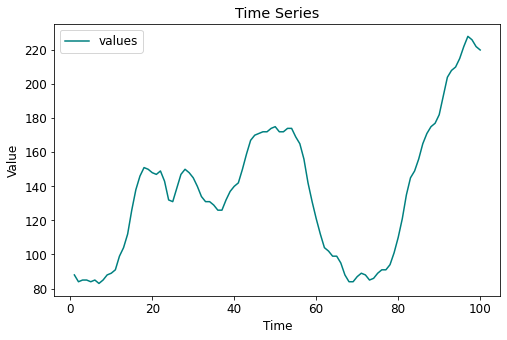

In [178]:
data.plot(figsize=(8,5), color='teal')
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [179]:
# Dividir en entrenamiento (80%) y prueba (20%)
train = data.iloc[:80]
test = data.iloc[80:]

In [180]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [181]:
adf_test(train)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


In [182]:
diff1_values = data.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = data.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.722238
p-value                         0.070268
#Lags Used                      2.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -9.929762e+00
p-value                        2.843429e-17
#Lags Used                     1.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Stationary


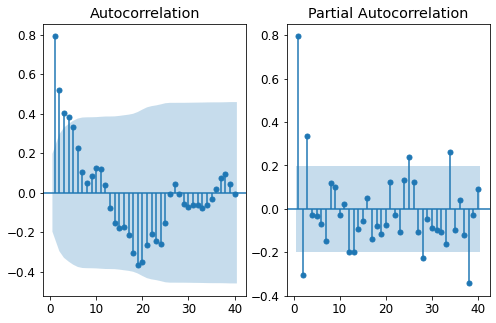

In [183]:
# 1. Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

plot_acf_pacf(diff1_values, {'lags':40})

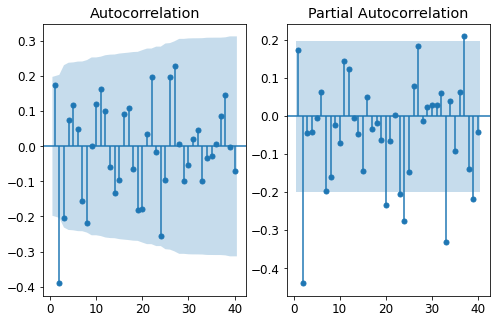

In [184]:
plot_acf_pacf(diff2_values, {'lags':40})

In [185]:
# 1. Modelo de diferencia de primer orden
arima_model_base = ARIMA(train, order=(3, 1, 4))
model_base = arima_model_base.fit()
print(model_base.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -200.168
Date:                Tue, 07 Feb 2023   AIC                            416.335
Time:                        12:05:07   BIC                            435.291
Sample:                             0   HQIC                           423.930
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5016      0.284      5.290      0.000       0.945       2.058
ar.L2         -1.0454      0.457     -2.290      0.022      -1.940      -0.150
ar.L3          0.1654      0.291      0.569      0.5

In [186]:
# 2. Modelo de diferencia de segundo orden
# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model_base2 = ARIMA(train, order=(ar, 2, ma))
model_base2 = arima_model_base2.fit()
print(model_base2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                -204.918
Date:                Tue, 07 Feb 2023   AIC                            415.836
Time:                        12:05:07   BIC                            422.906
Sample:                             0   HQIC                           418.666
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1580      0.299     -0.528      0.598      -0.744       0.428
ma.L2         -0.2139      0.299     -0.716      0.474      -0.799       0.372
sigma2        11.1660      2.019      5.531      0.0

In [187]:
# 1. Modelo de diferencia de primer orden
arima_model_1 = ARIMA(train, order=(3, 1, 1))
model_1 = arima_model_1.fit()
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -202.231
Date:                Tue, 07 Feb 2023   AIC                            414.462
Time:                        12:05:07   BIC                            426.309
Sample:                             0   HQIC                           419.209
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0024      0.437      2.295      0.022       0.146       1.858
ar.L2         -0.4731      0.475     -0.997      0.319      -1.403       0.457
ar.L3          0.2333      0.192      1.218      0.2

<AxesSubplot:>

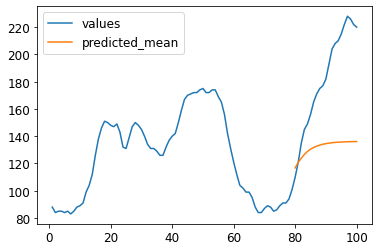

In [188]:
# Cómo realizar predicciones con el modelo ajustado
y_h = model_1.predict(start=80, end=100, dynamic=False).to_frame()
ax = data.plot()
y_h.plot(ax=ax)

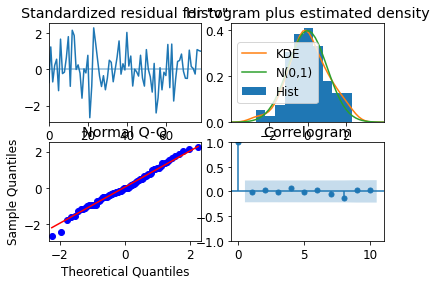

In [189]:
# Gráfico de los diagnósticos para los residuos
model_1.plot_diagnostics();

##### Código de solución estudiante 2

Cargamos Los datos y observamos la serie de tiempo con la que trabajaremos

In [190]:
data = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/WWWusage.csv', names=['values'], header=0)
data.index = data.index.droplevel()
data

,values
1,88
2,84
3,85
4,85
5,84
...,...
96,222
97,228
98,226
99,222


Dividimos los datos a usar

In [191]:
split = int(data.shape[0]*.8)
train = data[:split]
test = data[split:]
train.shape, test.shape

((80, 1), (20, 1))

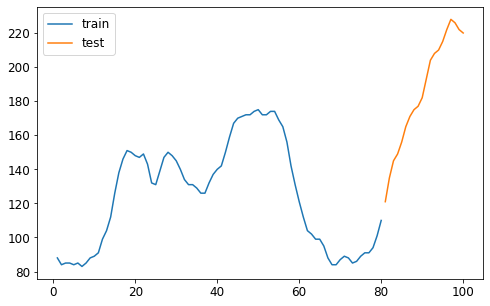

In [192]:
fig, ax = plt.subplots(figsize = (10, 5))
train.plot(figsize=(8,5), ax = ax,)
test.plot(figsize=(8,5), ax = ax)
ax.legend(labels = ['train', 'test'])

Graficamos el acf y pacf para decidir los parametros del ARIMA y observamos que parece ser no estacionaria, por lo que realizamos una prueba adf para asegurarnos

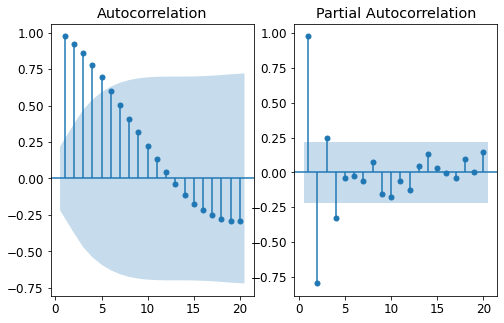

In [193]:
# Escoger parámetros de ARIMA
plot_acf_pacf(train)

Como vemos que no es estacionaria, hacemos el test para la diferenciada

In [194]:
adf_test(train)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


El set de datos de entrenamientonos da un valor cercano al 0.05, pero solamente la segunda derivada nos da uno menor, 

In [195]:
diff1_values = train.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = train.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


Volvemos a graficar el acf y pacf de los datos estacionarios elegidos

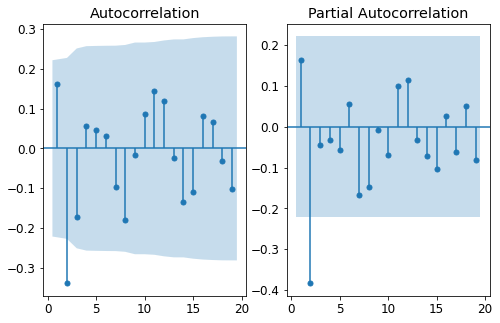

In [196]:
plot_acf_pacf(diff2_values)

Estos graficos nos indican un modelo con $p = 2, d = 2 \text{ y } q = 2$, o si nos arriesgamos a utilizar los datos sin diferenciar tendriamos un arima de $p = 4, d = 0 \text{ y } q = 5$

In [242]:
# 1. Modelo de diferencia de primer orden
arima_model1 = ARIMA(data, order=(4, 0, 5))
model1 = arima_model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                  100
Model:                 ARIMA(4, 0, 5)   Log Likelihood                -248.884
Date:                Tue, 07 Feb 2023   AIC                            519.767
Time:                        12:26:05   BIC                            548.424
Sample:                             0   HQIC                           531.365
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        137.0679      5.091     26.921      0.000     127.089     147.047
ar.L1          2.9287      0.088     33.403      0.000       2.757       3.101
ar.L2         -3.7320      0.229    -16.307      0.0

In [198]:
# 2. Modelo de diferencia de segundo orden

# Basado en lo discutido anteriormente, necesitamos sólo considerar algunos términos AR y MA.
# Para ello definimos sus coeficientos cómo la especificación de polinomios

# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model2 = ARIMA(train, order=(ar, 2, ma))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                -204.918
Date:                Tue, 07 Feb 2023   AIC                            415.836
Time:                        12:05:10   BIC                            422.906
Sample:                             0   HQIC                           418.666
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1580      0.299     -0.528      0.598      -0.744       0.428
ma.L2         -0.2139      0.299     -0.716      0.474      -0.799       0.372
sigma2        11.1660      2.019      5.531      0.0

De estos dos modelos es mejor el segundo, ya que la log es mayor y tanto el AIC como el BIC son menores, por lo que veremos una predicción de este modelo a continuación

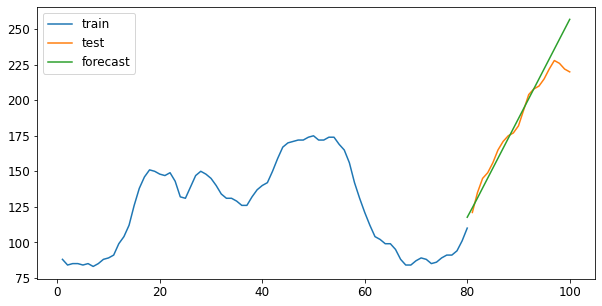

In [199]:
# Cómo realizar predicciones con el modelo ajustado
y_h = model2.predict(start=80, end=100, dynamic=False).to_frame()

fig, ax = plt.subplots(figsize = (10, 5))
train.plot(ax = ax)
test.plot(ax = ax)
y_h.plot(ax = ax)
ax.legend(labels = ['train', 'test', 'forecast'])

### Ejercicio 2: Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.

##### Código de solución estudiante 1

In [200]:
data = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()

In [201]:
# Dividir en entrenamiento (80%) y prueba (20%)
train = data.iloc[:80]
test = data.iloc[80:]

In [202]:
# Normalización
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train)

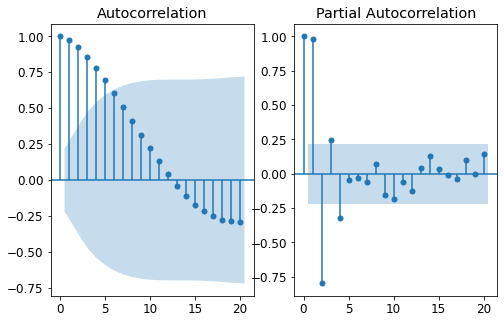

In [203]:
# Escoger parámetros de ARIMA

# 1. Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(scaled_data, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(scaled_data, ax=ax2, method='ols')

plt.show()

In [204]:
adf_test(scaled_data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


In [205]:
diff1_values = pd.DataFrame(scaled_data).diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = pd.DataFrame(scaled_data).diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


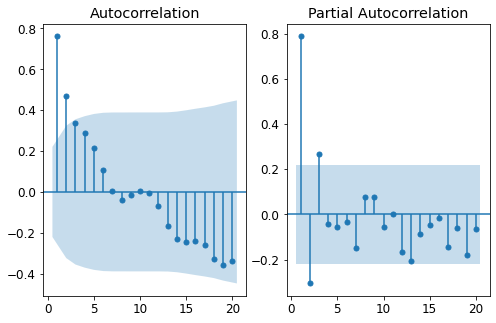

In [206]:
plot_acf_pacf(diff1_values, {'lags':20})

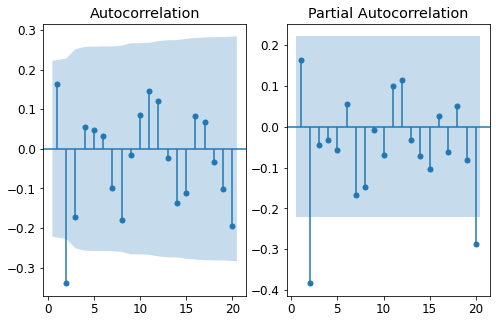

In [207]:
plot_acf_pacf(diff2_values, {'lags':20})

In [208]:
# 1. Modelo de diferencia de primer orden
arima_model_scaled_1 = ARIMA(scaled_data, order=(3, 1, 2))
model_scaled_1 = arima_model_scaled_1.fit()
print(model_scaled_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 155.332
Date:                Tue, 07 Feb 2023   AIC                           -298.664
Time:                        12:05:12   BIC                           -284.447
Sample:                             0   HQIC                          -292.968
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0263      0.347      0.076      0.940      -0.653       0.706
ar.L2          0.1147      0.294      0.390      0.696      -0.461       0.690
ar.L3          0.3262      0.223      1.464      0.1

In [209]:
# 2. Modelo de diferencia de segundo orden
# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model_scaled_2 = ARIMA(scaled_data, order=(ar, 2, ma))
model_scaled_2 = arima_model_scaled_2.fit()
print(model_scaled_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                 147.782
Date:                Tue, 07 Feb 2023   AIC                           -289.563
Time:                        12:05:13   BIC                           -282.493
Sample:                             0   HQIC                          -286.733
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1588      0.299     -0.531      0.595      -0.745       0.427
ma.L2         -0.2131      0.299     -0.713      0.476      -0.798       0.372
sigma2         0.0013      0.000      5.532      0.0

##### Código de solución estudiante 2

In [210]:
data = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()
split = int(data.shape[0]*.8)
train = data[:split]
test = data[split:]
train.shape, test.shape

((80, 1), (20, 1))

In [211]:
# Normalización
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_train = pd.DataFrame(scaled_train, columns=['value'])
scaled_train.index += 1
scaled_train

,value
1,0.054348
2,0.010870
3,0.021739
4,0.021739
5,0.010870
...,...
76,0.086957
77,0.086957
78,0.119565
79,0.195652


Vemos que cuando menos el acf y el pacf se ven muy similares, por lo que probaremos el adf

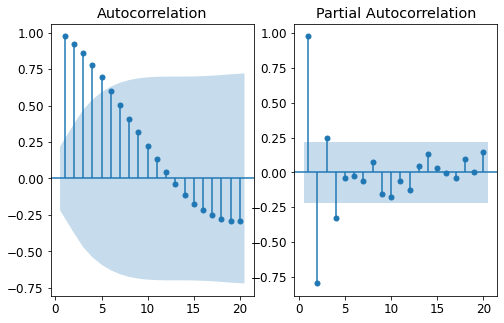

In [212]:
plot_acf_pacf(scaled_train)

Observamos que tenemos los mismos resultados en el adf que los que poseíamos la vez pasada, por lo que hasta ahora no parece que normalizar haya tenido efecto alguno

In [213]:
adf_test(scaled_train)

diff1_values = scaled_train.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = scaled_train.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)       

Graficamos el acf y pacf de los datos estacionarios

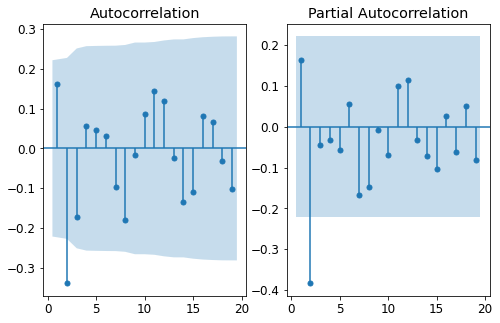

In [214]:
plot_acf_pacf(diff2_values)

Y el modelo, en el cual podemos ver un aumento en la log verosímilitud y una disminución el en AIC y el BIC, lo cuál es bueno

In [215]:
# 2. Modelo de diferencia de segundo orden

# Basado en lo discutido anteriormente, necesitamos sólo considerar algunos términos AR y MA.
# Para ello definimos sus coeficientos cómo la especificación de polinomios

# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model2 = ARIMA(scaled_train, order=(ar, 2, ma))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                 147.782
Date:                Tue, 07 Feb 2023   AIC                           -289.563
Time:                        12:05:14   BIC                           -282.493
Sample:                             0   HQIC                          -286.733
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1588      0.299     -0.531      0.595      -0.745       0.427
ma.L2         -0.2131      0.299     -0.713      0.476      -0.798       0.372
sigma2         0.0013      0.000      5.532      0.0

Vemos que nos da una predicción similar a lo que teniamos en nuestro modelo sin escalar

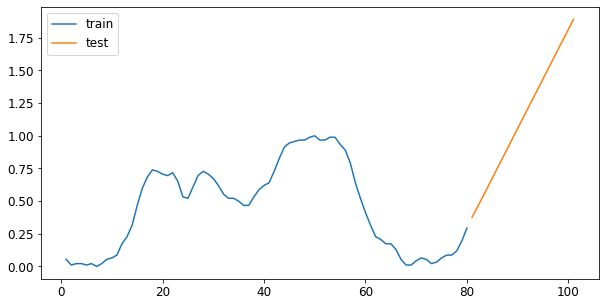

In [216]:
# Cómo realizar predicciones con el modelo ajustado
y_h_scaled = model2.predict(start=80, end=100, dynamic=False).to_frame()

fig, ax = plt.subplots(figsize = (10, 5))
scaled_train.plot(ax = ax)
y_h_scaled.plot(ax = ax)
ax.legend(labels = ['train', 'test', 'forecast'])

### Ejercicio 3: Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado.

##### Código de solución estudiante 1

In [217]:
# Código de solución estudiante 1

SyntaxError: invalid syntax (Temp/ipykernel_5584/4014612766.py, line 2)

##### Código de solución estudiante 2

Utilizando el link recomendado: https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/

In [250]:
from datetime import datetime
import requests as request

air2 = request.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
data2.drop(['time', 't'], axis = 1, inplace = True)
data2.head()

,air
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [264]:
split = int(data2.shape[0]*.8)
train_2 = data2[:split]
test_2 = data2[split:]
data2.shape, train_2.shape, test_2.shape

((144, 1), (115, 1), (29, 1))

<AxesSubplot:>

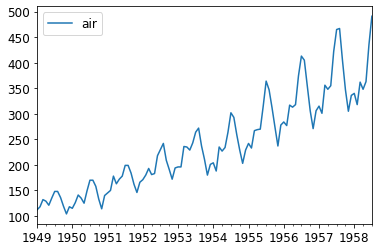

In [265]:
train_2.plot()

Vemos la serie por partes, viendo la tendencia, estacionalidad y residuos

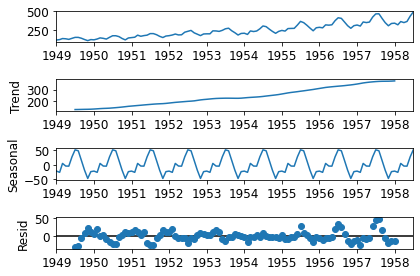

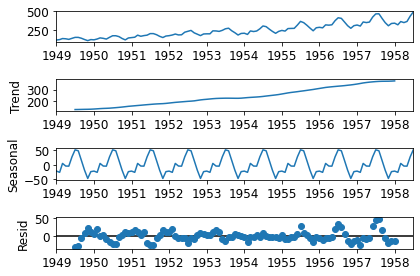

In [266]:
decompose_data2 = seasonal_decompose(train_2, model = 'additive')
decompose_data2.plot()

Podemos ver la estacionalidad de manera separada

<AxesSubplot:>

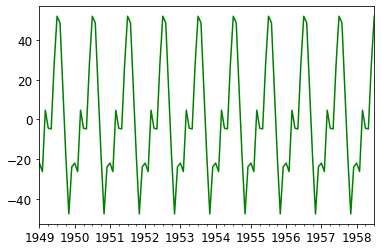

In [267]:
seasonality=decompose_data2.seasonal
seasonality.plot(color='green')

Aunque parece ser estacional, cuando realizamos la prueba ADF, podemos comporbar que si lo es, por lo que deberemos de aplicar un SARIMAX

In [268]:
adf_test(train_2)

Results of Dickey-Fuller Test:
Test Statistic                  -0.356889
p-value                          0.917052
#Lags Used                      13.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
Non-stationary


Implementamos el modelo

In [269]:
sa_model = sm.tsa.statespace.SARIMAX(train_2 ,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results = sa_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                air   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -374.130
Date:                            Tue, 07 Feb 2023   AIC                            758.260
Time:                                    12:34:12   BIC                            771.385
Sample:                                01-01-1949   HQIC                           763.575
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6366      0.334     -1.908      0.056      -1.290       0.017
ma.L1          0.4605      0.372      1.237      0.216      -0.269       1.190
ar.S.L12      -0.3550      0.670     -0.530      0.596      -1.669       0.959
ma.S.L12       0.2286      0.721      0.317      0.751      -1.184       1.641
sigma2        89.5753     14.373      6.232      0.000      61.405     117.745
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.92   Prob(JB):                         0.27
Heteroskedasticity (H):               1.18   Skew:                             0.33
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

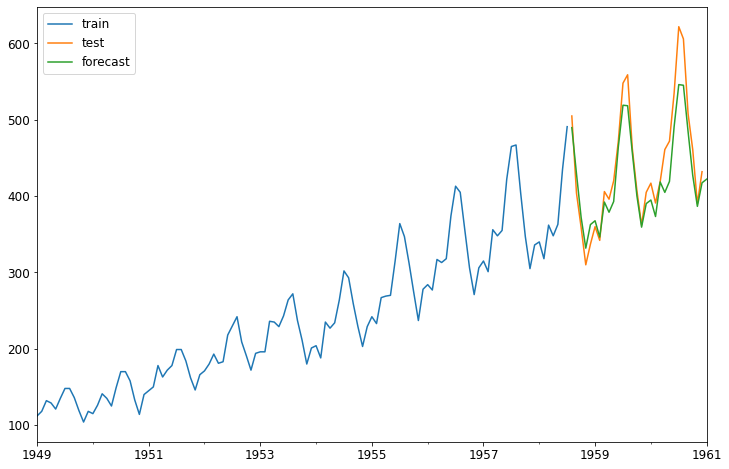

In [272]:
data2_pred = results.predict(start=115,end=144,dynamic=False)

fig, ax = plt.subplots(figsize=(12,8))
train_2.plot(ax = ax)
test_2.plot(ax =ax)
data2_pred.plot(ax = ax)
ax.legend(labels = ['train', 'test', 'forecast'])

Si lo quisieramos realizar con un modelo ARIMa deberiamos diferenciar la serie primero

In [275]:
diff1_values = train_2.diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = train_2.diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                  -2.539635
p-value                          0.106126
#Lags Used                      13.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -6.932644e+00
p-value                        1.074274e-09
#Lags Used                     1.300000e+01
Number of Observations Used    9.900000e+01
Critical Value (1%)           -3.498198e+00
Critical Value (5%)           -2.891208e+00
Critical Value (10%)          -2.582596e+00
dtype: float64
Stationary


Ya que sabemos que la segunda derivada es estacionaria entonces podemos graficar afc y pacf

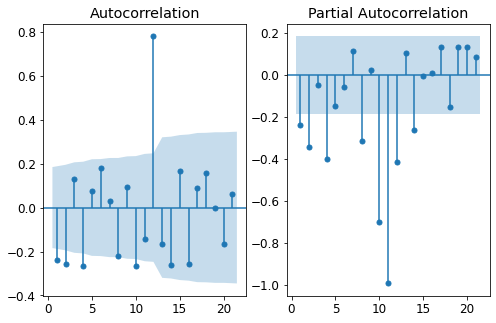

In [276]:
plot_acf_pacf(diff2_values)

E implementar un modelo ARIMA

In [293]:
# 2. Modelo de diferencia de segundo orden

# Basado en lo discutido anteriormente, necesitamos sólo considerar algunos términos AR y MA.
# Para ello definimos sus coeficientos cómo la especificación de polinomios

# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model2 = ARIMA(train_2, order=(ar, 2, ma))
model2 = arima_model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                    air   No. Observations:                  115
Model:             ARIMA([2], 2, [2])   Log Likelihood                -537.202
Date:                Tue, 07 Feb 2023   AIC                           1080.405
Time:                        12:46:22   BIC                           1088.587
Sample:                    01-01-1949   HQIC                          1083.725
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2          0.3839      0.130      2.947      0.003       0.129       0.639
ma.L2         -0.8999      0.063    -14.176      0.000      -1.024      -0.775
sigma2       775.0714    121.376      6.386      0.0

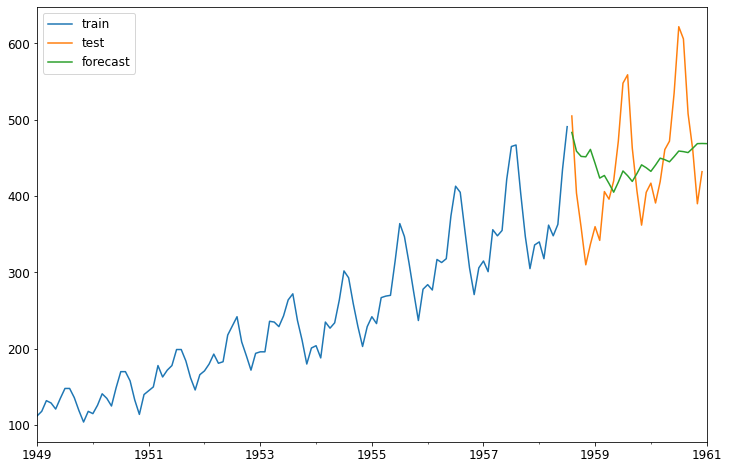

In [292]:
arima_pred = model2.predict(start=115,end=144,dynamic=False)

fig, ax = plt.subplots(figsize=(12,8))
train_2.plot(ax = ax)
test_2.plot(ax =ax)
arima_pred.plot(ax = ax)
ax.legend(labels = ['train', 'test', 'forecast'])

### Ejercicio 4: Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos.

##### Código de solución estudiante 1

In [257]:
# Código de solución estudiante 1


##### Código de solución estudiante 2

Podemos observar los resultados del modelo ARIMa y del modelo SARIMAx en nuestra gráfica

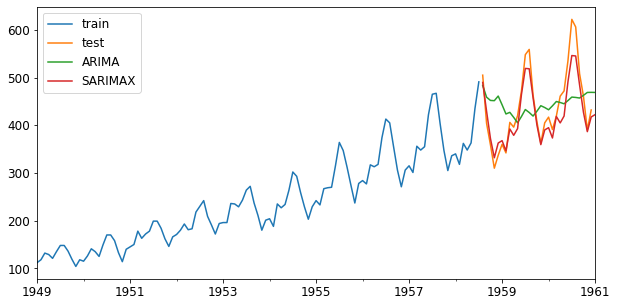

In [295]:
fig, ax = plt.subplots(figsize = (10, 5))
train_2.plot(ax = ax)
test_2.plot(ax = ax)
arima_pred.plot(ax = ax)
data2_pred.plot(ax = ax)
ax.legend(labels = ['train', 'test', 'ARIMA', 'SARIMAX'])

Si vemos solamente los que se predijeron

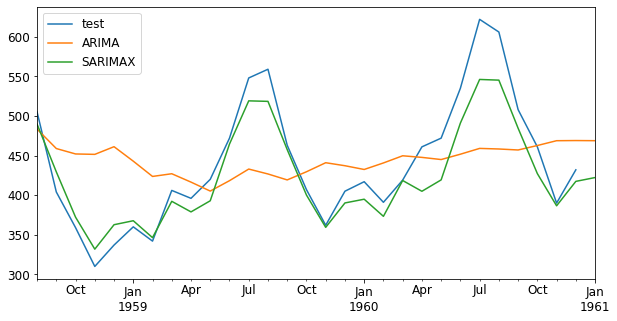

In [298]:
fig, ax = plt.subplots(figsize = (10, 5))
test_2.plot(ax = ax)
arima_pred.plot(ax = ax)
data2_pred.plot(ax = ax)
ax.legend(labels = ['test', 'ARIMA', 'SARIMAX'])

por lo que vemos que realmente el modelo SARIMAX produce mejores resultados